In [1]:
from scipy.optimize import minimize
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import cpu_count, Pool
from numpy.linalg import inv, det
from astropy.io import ascii
from scipy.optimize import minimize, rosen, rosen_der
from scipy import interpolate
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
import emcee
import multiprocessing
import corner

plt.rcParams['savefig.facecolor'] = 'white'
multiprocessing.set_start_method('fork')

In [2]:
# Fourier function, Eq. 7 in the paper
def function_fourier_fit(a, t):
    
    ret = a[0] + a[1]*np.sin(2*np.pi*(t)) + a[2]*np.cos(2*np.pi*(t))
    i = 0

    for deg in range(3, len(a),2):
        i+=1
        ret += a[deg]*np.sin(2*(i+1)*np.pi*(t)) + a[deg+1]*np.cos(2*(i+1)*np.pi*(t))

    return ret


# Log-normal distribution
def ln_normal(dy, std):
    return -0.5 * (dy)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

# BH-Aur     --- RRab type

In [3]:
name_star = "RRab"

# Spectroscopic data obtained from the analysis of APOGEE subvisits
line_of_sight_velocity = np.array([53.4151, 55.2590, 57.1008, 62.2640]) # corr for Heliocentric vel.
uncertainty_line_of_sight_velocity = np.array([0.338297, 0.504453, 1.723845, 3.625235])      
time_of_observations = np.array([2457428.816665, 2457428.828389, 2457428.8401, 2457428.851875]) # HJD


# Photometric information on BH Aur
amplitude_Gband             = 0.805501 # mag
uncertainty_amplitude_Gband = 0.029144509 # mag
pulsation_period            = 0.4560898 # day
time_of_brighness_maxima    = 2455197.5+1710.2783865285412 # day


#line_of_sight_velocity = np.array([-69.152, -61.657]) # corr for Heliocentric vel.
#uncertainty_line_of_sight_velocity = np.array([2.273, 1.511])      
#time_of_observations = np.array([2458059.4987222, 2458626.8885229]) # HJD

# 'Ground truth' from Gaia data
gaia_vsys, error_gaia_vsys = 51.393063, 1.4457822

## Amplitude scaling relation

In [4]:
# Equation 5 in the paper
scaling_relation = np.array([-64., 127])  

# Equation 7 in the paper
covariance_matrix_scaling_relation_RRab = np.array([[120. , -98.], 
                                                    [-98. ,  81.]])

## Template and scatter in template

In [5]:
# Table 2, first row in the paper
template_fourier = np.array([0.0000, -0.2667, -0.2806, 
                             -0.0351, -0.1358, 0.0222, 
                             -0.0884, 0.0455, -0.0300, 
                             0.0192, -0.0016]) 

# Table B3
err_apo = np.array([[0.000, 0.054, 0.083],
                    [0.025, 0.054, 0.083],
                    [0.075, 0.059, 0.087],
                    [0.125, 0.064, 0.115],
                    [0.175, 0.028, 0.081],
                    [0.225, 0.064, 0.068],
                    [0.275, 0.056, 0.074],
                    [0.325, 0.040, 0.069],
                    [0.375, 0.033, 0.080],
                    [0.425, 0.044, 0.108],
                    [0.475, 0.073, 0.127],
                    [0.525, 0.046, 0.101],
                    [0.575, 0.049, 0.078],
                    [0.625, 0.069, 0.117],
                    [0.675, 0.051, 0.120],
                    [0.725, 0.066, 0.092],
                    [0.775, 0.057, 0.149],
                    [0.825, 0.050, 0.391],
                    [0.875, 0.159, 0.220],
                    [0.925, 0.186, 0.215],
                    [0.975, 0.070, 0.109],
                    [1.000, 0.070, 0.109]])
# Table B3, first column in the paper
phase_for_scatter_in_template = err_apo[:,0]  

# Table B3, second column in the paper
scatter_in_template = err_apo[:,1]           

# Spline function that interpolates the discrete scatter along the pulsation phase
f_spline_err = interpolate.interp1d(phase_for_scatter_in_template, 
                                    scatter_in_template, 
                                    kind='linear')

In [6]:
vector = np.array([amplitude_Gband**2, amplitude_Gband])
derivative_vector = np.array([amplitude_Gband, 1.0])
        
Amp_line_of_sight_vel = scaling_relation @ vector 
uncertainty_Amp_line_of_sight_vel = np.sqrt(vector @ covariance_matrix_scaling_relation_RRab @ vector.T 
                                                    + ((scaling_relation @ derivative_vector)**2)*(uncertainty_amplitude_Gband**2))                                          

print(r"Predicted amplitude of the line of sight velocity and its error is: %.1f ± %.1f kms-1" %(Amp_line_of_sight_vel, 
                                                                                                 uncertainty_Amp_line_of_sight_vel))

Predicted amplitude of the line of sight velocity and its error is: 60.8 ± 2.3 kms-1


### Systemic velocity estimation

In [7]:
def systematic_velocity_determ(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    
    vsys = param

    # Equation 21 in paper
    phase_star = np.mod(HJD - M0, P) / P
    
    # Equation 19 in paper
    model_velocity = function_fourier_fit(template_fourier, phase_star)*Alos + vsys

    # Equation 20 in paper
    evel_fin = np.sqrt(uncertainty_measured_velocity**2 
                       + (f_spline_err(phase_star)*Alos)**2 
                       + (function_fourier_fit(template_fourier,phase_star)*eAlos)**2 )

    # Equation 18 in paper
    result = ln_normal(measured_velocity - model_velocity, evel_fin) 

    
    return np.nansum(result[np.isfinite(result)])


# Possibility for including some priors
def prior(param):
    # pick a prior
    return 0.

#    
def LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    
    lp = prior(param)
    
    rety = systematic_velocity_determ(param, HJD, measured_velocity, 
                                      uncertainty_measured_velocity, 
                                      P, M0, Alos, eAlos) 

    return lp + rety


def LOG_minus(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    return -LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos)

# --- Scipy way ---

In [8]:
p0 = np.array([-11.])

res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                      line_of_sight_velocity, 
                                      uncertainty_line_of_sight_velocity, 
                                      pulsation_period, 
                                      time_of_brighness_maxima, 
                                      Amp_line_of_sight_vel, 
                                      uncertainty_Amp_line_of_sight_vel), method='BFGS') #SLSQP


print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))

Determined systemic velocity and its uncertainty is: 49.7 ± 1.6 kms-1


In [9]:
nwalkers, ndim = 100, len(res.x)
    
pos = np.random.multivariate_normal(res.x, res.hess_inv, nwalkers)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, LOG_probability,
                                         args=(time_of_observations, line_of_sight_velocity, 
                                               uncertainty_line_of_sight_velocity, pulsation_period, 
                                               time_of_brighness_maxima, Amp_line_of_sight_vel, 
                                               uncertainty_Amp_line_of_sight_vel),
                                         pool=pool) # , backend=backend
        
    state = sampler.run_mcmc(pos, 1000, progress=True)
    sampler.reset()
    sampler.run_mcmc(state, 20000, progress=True);

100%|████████████████████████████████████| 20000/20000 [00:58<00:00, 340.78it/s]


In [10]:
print( "Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)) )

Mean acceptance fraction: 0.808


In [13]:
samples = sampler.get_chain(discard=19000, thin=10, flat=True)

print( "Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %( np.average(samples[:,0]), 
                                                                                   np.std(samples[:,0])) )

Determined systemic velocity and its uncertainty is: 49.7 ± 1.6 kms-1


### Hist to compare

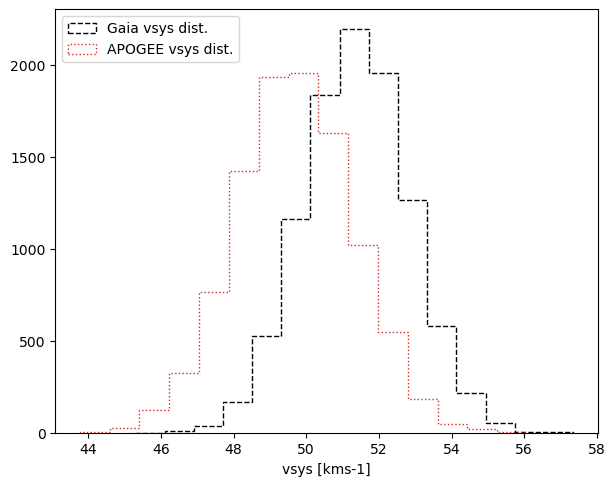

In [33]:
bins = 15

yhist, xhist = np.histogram(samples[:,0], bins=bins, density=True)
# gaia_vsys, error_gaia_vsys = 51.393063, 1.4457822


fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(7, 5.5))
axs.hist(np.random.normal(gaia_vsys, error_gaia_vsys, len(samples[:,0])), 
         color="k",
         histtype="step", 
         lw=1, 
         bins=bins,
         ls="--",
         label="Gaia vsys dist.", 
         density=False)

axs.hist(np.random.normal(49.7, 1.6, len(samples[:,0])), 
         color="C3", 
         histtype="step", 
         lw=1, 
         bins=xhist,
         ls=":",
         label="APOGEE vsys dist.", 
         density=False)

axs.legend(loc=2)


axs.set_xlabel("vsys [kms-1]")

plt.show()

## Check data and systemic velocity

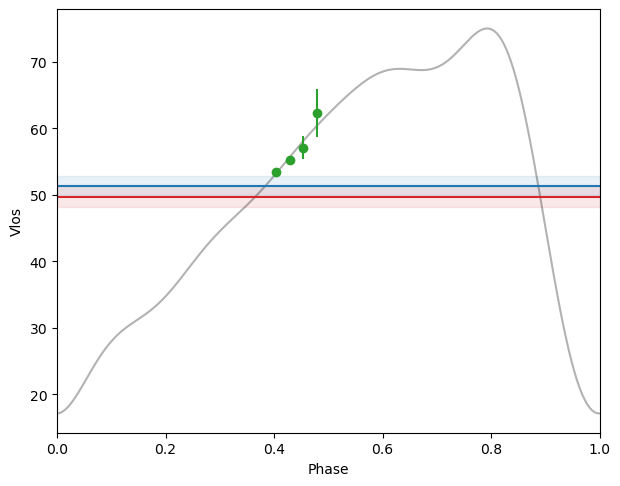

In [34]:
phase_star = np.mod(time_of_observations - time_of_brighness_maxima, pulsation_period) / pulsation_period

phase_star_model = np.linspace(0, 1, 1000)

model_velocity_rrab1 = function_fourier_fit(template_fourier, phase_star_model)*Amp_line_of_sight_vel + res.x[0]

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(7, 5.5))

axs.plot(phase_star_model, model_velocity_rrab1, c="k",alpha=0.3)
axs.errorbar(phase_star, line_of_sight_velocity, yerr=uncertainty_line_of_sight_velocity, fmt="o", c="C2")
axs.set_xlabel("Phase")
axs.set_ylabel("Vlos")
axs.fill_between(np.linspace(0,1,10), 
                 np.ones(10)*51.393063 + 1.4457822, 
                 np.ones(10)*51.393063 - 1.4457822, alpha=0.1, color="C0")
axs.fill_between(np.linspace(0,1,10), 
                 np.ones(10)*49.7 + 1.6, 
                 np.ones(10)*49.7 - 1.6, alpha=0.1, color="C3")
axs.axhline(51.4, c="C0", label="Gaia vsys")
axs.axhline(49.7, c="C3", label="APOGEE vsys")
axs.set_xlim(0,1)
plt.show()